## USING PYMC library
PyMC is a library for Bayesian inference, which allows us to run Markov Chain Monte Carlo simulations, and use them to do estimations or sample from distributions.

In this file, we will illustrate two basic examples that should give an idea on how to use the library. 
You can check the online documentation at https://pymc-devs.github.io/pymc/index.html

At the end of the notebook, there is an exercise to start using the library for parameter inference in Markov models. 

In [36]:
%matplotlib inline

In [37]:
import numpy as np
from pymc import Normal, Categorical, deterministic, Model, MCMC, stochastic, Beta, MAP
from pymc.Matplot import plot
from pylab import hist, show
from numpy.random import choice
import math

#### Sampling from a distribution
In this example we sample from a mixture of two Gaussians.
The idea to define it is to use both built-in variables of PyMC and user defined variables, in this case deterministic.

The root variable (i.e. the indepedent one) is a **stochastic** `Categorical` one, which chooses the component of the mixture.
Given this variable, we define two **deterministic** functions, which take the value of the categorical variable and return mean and precision (1/variance) of the corresponding Gaussian component. These are constructed using a python decorator, `@deterministic` which applies a PyMC function (`determinstic`) to what comes after. It is like defining e.g. `mu`, and then having a line like `mu = deterministic(mu)`. 

Then another stochastic variable, `Normal`, is defined, with mean and precision calculated above. 
Finally a PyMC model is constructed.

In [38]:
#build a pymc model: this is a mixture of Gaussians. 
#This is the model we will sample from 
sigmas = [1,1]
centers = [0,3]
alpha=0.8
category = Categorical("category", [alpha, 1 - alpha])

@deterministic
def mu(category=category, centers=centers):
    return centers[category]

@deterministic
def tau(category=category, sigmas=sigmas):
    return 1/(sigmas[category]**2)

mixture = Normal('mixture', mu=mu, tau=tau)
model = Model([mixture])


##### Sampling from a model
The hard part is building the model. The sampling is easy: one defines a MCMC object, samples it, and the plots the trace of the variables of interest (note how each variable has a name to identify it).

In [39]:
#MCMC sampling
M = MCMC(model)
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sec

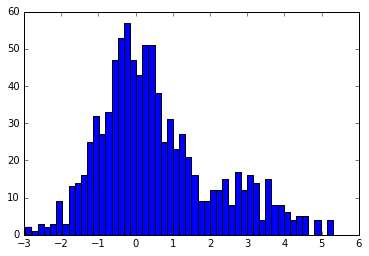

In [40]:
#plot(M)
hist(M.trace('mixture')[:],bins=50)
show()


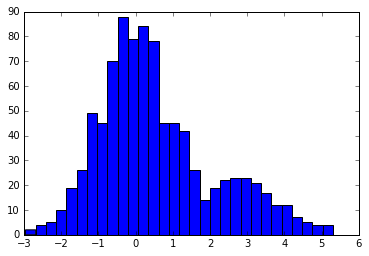

In [41]:
#plot(M)
hist(M.trace('mixture')[:],bins=math.floor(math.sqrt(len(M.trace('mixture')[:]))))
show()

#### Bayesian inference and user defined stochastic variables
Here we want to do Bayesian inference for a Bernoulli r.v. with parameter p. 
We will define a prior for p, in this case a uniform Beta, then build a user defined model for the Bernoulli variable.

The user defined process uses a `@stochastic` decorator, in this case flagging `observed = True`, which assumes the output of this process is observed. One defines two subfunctions, one computing the log-likelihood and the second to sample from it. Note how the value passed to `my_process` is the vector of the observed values, and we need to compute the log-likelihood of the whole vector in `logp`. 

In [42]:
#sets us an uniform prior
a = 1
b = 1
beta = Beta('parameter',a,b)

#generates observations
N_obs = 1000
p_true = 0.67
observed_values = choice(2, N_obs, p=[1-p_true,p_true])

@stochastic(observed = True, dtype = np.int)
def my_process(value = observed_values, prob = beta):
    """An example of a user defined stochastic process."""

    def logp(value,prob):
        if prob > 1 or prob < 0:
            return -np.inf
        else:
            return np.sum(value*np.log(prob) + (1-value)* np.log(1-prob))

    def random(prob):
        return choice(2, 1, p=[1-prob,prob])
    

##### Posterior approximation or MAP
Once the model is defined, we can sample from the posterior of the parameter, given the observations, or do Maximum a posteriori inference. 

 [-----------------100%-----------------] 10000 of 10000 complete in 0.5 sec

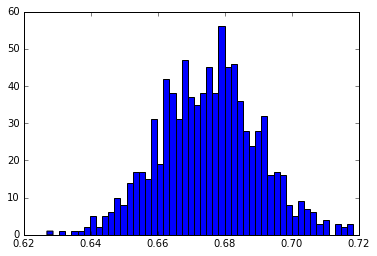

In [43]:
model_inference = Model([my_process,beta])
M = MCMC(model_inference)
M.sample(iter=10000, burn=1000, thin=10)
hist(M.trace('parameter')[:],bins=50)
show()


In [44]:
Mp = MAP(model_inference)
Mp.fit()
p_opt =  Mp.get_node('parameter').get_value()
BIC = Mp.BIC
print("optimal value of parameter is",p_opt,"BIC is",BIC)


optimal value of parameter is 0.6759999969737311 BIC is 1266.6034761997391


### Exercise
Do inference for a gaussian mixture model with 3 components, using the data in moodle for soft clustering with mixtures of Gaussians. Infer both the mixture wegihts and the Gaussian parameters. What do you expect? Unimodal distributions for (vedi moodle)